In [1]:
%run ../Config/ImgConfig.ipynb
HTML("""<style>.jp-OutputArea-output {display: table-cell;text-align: center !important;vertical-align: middle !important;}.jp-OutputArea-output img {width: 70% !important;}</style>""")

# 5. Forecasting

[index](../Index.ipynb) | [prev](./04.DataCollection.ipynb) | [next](./06.AnomalyDetection.ipynb)

**Motivation**:

Can detected objects be used as a dataset to predict future object counts?

Asking this question has changed my perspective about this project. Initially it was solely about Object Detection pipeline, however when that was done, I began to look at images as a valuable data source with diverse applications.

Forecasting expected object counts can be very beneficial. At allows for informed planning decisions and anomaly detection. For example, if the predicted number of people at 3PM on a weekend-day is $5$, and the observed count is $15$, then something unusual might be taking place, and perhaps a user would like to be notified about it.

**Time interval**:

It is important to decide on the time interval for the forecast.

I have explored several intervals, including 15-minutes, 1-hour and 3-hour windows, but the 1 hour turned out to be the best choice for the following reasons:

- 15 minute forecast is too noisy and it is too difficult to predict object counts with high accuracy
- 3 hour window is too large and reduces the data size too much
- 1 hour is a good trade-off

This value will depend on the use case and the available data and it should be made customizable.

**This Chapter**:

This Notebook is an in-depth study of the steps taken to generate such a forecast:

- data extraction and clean up of raw images
- counting objects paradigm
- more data preparation
- additional data sources
- exploratory data analysis (EDA)
- forecasting

Forecast needs to be generated for a specific object type (like a *Person* or *Vehicle*). 

The [Conclusion](#conclusion) section in the bottom will summarize the findings, where the best model, which should be used going forward will be identified.

**Notes**:

- Code samples with comments and more plots are available in [Extra Notebook 5](../Notebooks/Extra.05.Person-EDA-Forecast.ipynb)
- To keep this chapter well organized and concise, I have only included a study on *Person* class (but the approach is generic and should work for all object classes)
- For model comparisons I have used following metrics:
    - MPD - Mean Poisson Deviance
    - MSE - Mean Squared Error
    - MAE - Mean Absolute Error
    - R2 - R2 Score
    - ACC - Accuracy

## 5.1. Extract raw image data

In order to perform forecasting, historical data is needed. In case of this research, the historical data are the images with detections, which need to be pre-processed and turned into a tabular format, which will allow further analysis.

This is where Python as a general purpose programming language can help. Below is a list of steps used to accomplish this goal:

- start with images, which are stored on the hard drive
- scan through all directories representing dates and find all images within these directories
- resize images to $608\times608$ px and use Yolo to detect objects
- keep saving all detections for each day in a csv file (just in case processing fails)
- load all images from csv files into a single, large Pandas DataFrame
- save dataframe with the whole dataset into an efficient .parquet format

A sample of the processed dataset is presented below:

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.1. Detections tabular data</p>

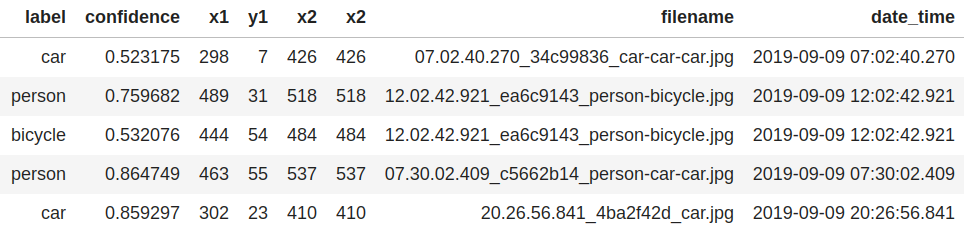

In [2]:
Image("../Resources/img/fcst-detections.png")

The dataset contains object classes under `label` feature, object detector's `confidence`, `x,y` coordinates for bounding boxes around detected objects, `filename` of the image, `date and time` of the detection, and a few more less interesting properties.

There are $643,471$ records with detections, which came from $222,195$ unique images, which yields $2.9$ objects per image on average.

The implementation details and more commentary for this transformation can be found in the [Extra Notebook 2](../Notebooks/Extra.02.ExtractRawImageData.ipynb).

## 5.2. Count objects in frame sequences

The next step in the data pre-processing is to determine a method to count objects in a given hour.

First, some cleaning was required. Throughout the data collection process, there were three days of downtime, so any data collected randomly for these days needed to be purged.

Now it is beneficial to observe a distribution of classes captured by the object detection pipeline:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.2. Class Distribution</p>


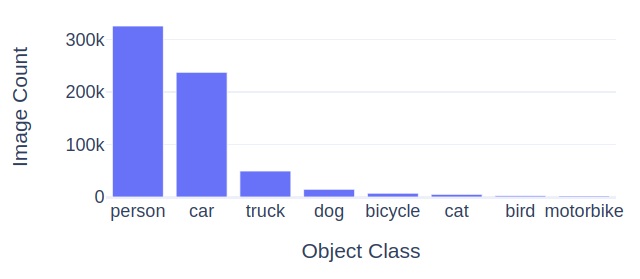

In [3]:
Image("../Resources/img/fcst-class-dist.png")

This picture shows a significant disproportion between the first two classes and the rest.

Based on this distribution I have decided to merge *cars* and *trucks* into a *vehicle* class and focus on predictions for *Person* and *Vehicle* only.

The iterative approach I took to counting objects in an hour is quite simple and works well for a dataset with a low number of objects/events:

- sort data by time
- split dataset by object type (label) and perform following tasks for each:
    - iterate through all detections
    - calculate difference in time between consecutive observations
    - calculate centroid for the detected boxes: $x_{center}=(x_{left}+x_{right})/2$, $y_{center}=(y_{top}+y_{bottom})/2$
    - use $x_{center}$, $y_{center}$ centroid coordinates to calculate an Euclidean Distance between object centroids in consecutive frames, if it is the same observation in a sequence, then the center will be close to the previous center
    - keep only objects where the difference in time and distance are greater than the predefined thresholds (these have been initially set using heuristics and will change depending on the camera and its location, please see plots below for more details)

The formula to calculate the distance is the well known Pythagorean metric:

$$
d= \sqrt{(x1-x2)^2+(y1-y2)^2}
$$

The algorithm above works well with the following threshold parameters:

- `THRESH_NEW_EVENT_SECS = 10` - Time after which we treat another observation as unique count
- `THRESH_NEW_EVENT_MIN_DISTANCE = 30` - Distance in pixels between centroids

There are multiple results from this pre-processing step (one for each object class), but a sample from the *Person* dataset is provided below and it represents unique observations extracted from sequences:

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.3. Unique detections</p>

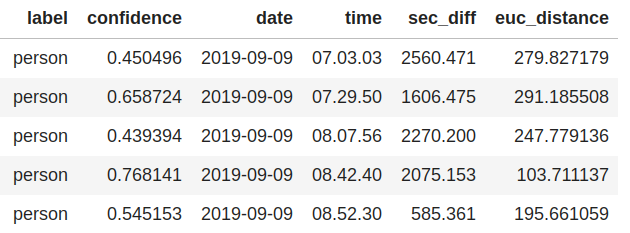

In [4]:
Image("../Resources/img/fcst-unique-detections.png")

This dataset only contains observations for a single class label and adds a `time difference` and `euclidean distance` versus a previous image. The shape is $4790\times26$.

To confirm the validity of the method, below are two distributions: left one showing Euclidean Distance calculated in pixels, and right one showing difference in seconds between observations:

<p style="text-align: center; margin-bottom: 4px;">Fig. 5.4. Distance metrics</p>

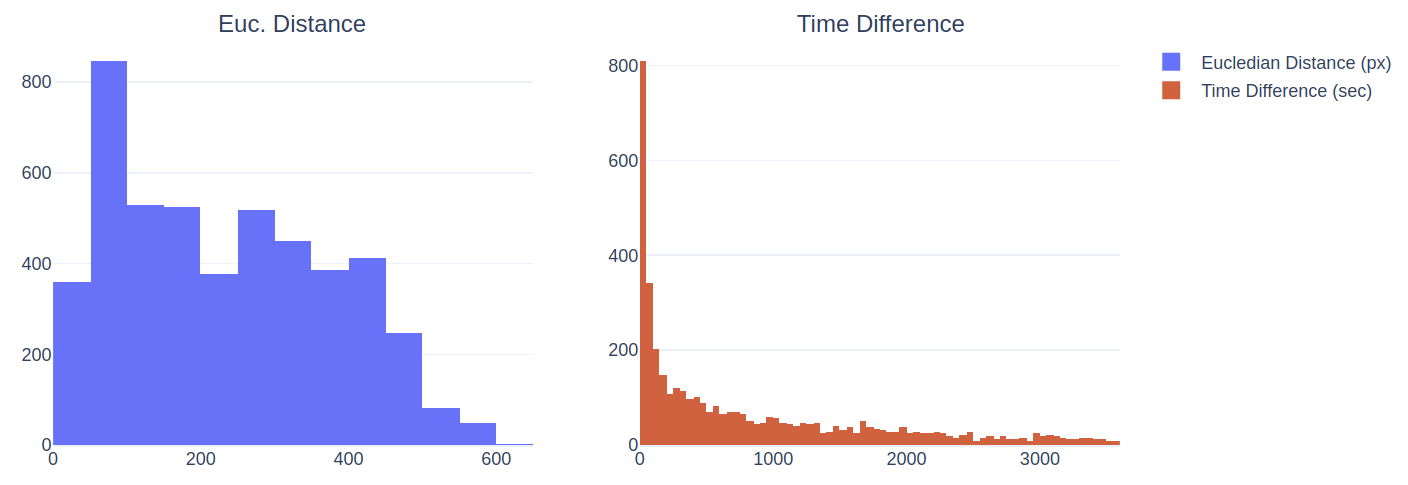

In [6]:
Image("../Resources/img/fcst-euc-dist.png")

**Plots interpretation:**

It can be observed that there tends to be a quite wide distribution of pixel differences between objects with 50 to 100 pixels being the most probable range. The x-values in the graph make sense as the images are $608\times608$ px in size.

The differences in time between objects are a little bit surprising with majority of objects being captured between 0 and 50 seconds between each other. Perhaps increasing the time between objects could be an interesting tweak to explore (I am leaving this for the future work on this project).

The implementation details and more commentary for this data transformation can be found in the [Extra Notebook 2 - ObjectCount](../Notebooks/Extra.02.ObjectCount.ipynb):

## 5.3. Further data preparation

One can very quickly notice that the majority of work in the real-life data driven/Machine Learning projects is cleaning and preparing the data.

Following this trend, the next step is to roll up the dataset to daily/hourly level.

[Pandas](https://pandas.pydata.org/) is a useful tool for working with dates and has a `resample` method, which allows to aggregate the data to hourly level and fill the gaps with no observations as $0$'s.

When this is done, more time-related features can be created, like:

- `hour`
- `n_month`
- `is_weekend_day`

Below are a sample two records of the dataset after this step of data preparation with the full code is included in an [Extra Notebook 5](../Notebooks/Extra.05.Person-EDA-Forecast.ipynb):

<p style="text-align: center; margin-bottom: 8px;">Fig. 5.5. Object counts data</p>

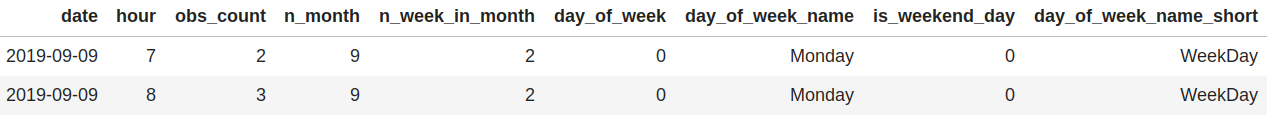

In [7]:
Image("../Resources/img/fcst-object-counts.png")

## 5.4. Weather data

I have also pulled 6 months of historical weather data to analyze if merging this data with the historical object counts can increase the prediction accuracy.

It turns out that [DarkSky](https://darksky.net) - one of the most popular weather applications, has an API, which can be used for free up to $1,000$ requests per day (note that it does not take any new registrations after recent acquisition by Apple).

Pandas `date_range` function can be used to generate a range of DateTime objects with an hourly interval, which need to be converted to Unix Timestamps.

Making an API request is a simple `GET` HTTP request to *https://api.darksky.net/forecast* with an `API_KEY` (received during registration to the service) and a `latitude`,`longitude` parameters for the desired location. For my house it is:

$$lat=51.802931199999996, long=-8.302591999999999$$

Pulling this data for six months at hourly interval generates $4224$ data points with $24$ features.

The questions that are possible to answer now are:

- did it rain at 8AM on Monday?
- was there a storm last Friday at 4PM?
- what was the temperature yesterday at midday?

Full details and code to generate this dataset is located in the Notebooks folder as [Extra Notebook 4](../Notebooks/Extra.04.FetchWeatherData.ipynb).

## 5.5. Exploratory data analysis (EDA)

Once the object counts data is prepared and weather data fetched, these two data sources can be combined using a common `timestamp` attribute. This merged dataset is now a basis for data analysis and forecasting.

**Target variable distribution**

The variable to predict is the number of object counts within an hour. 

It is expected that it is dominated by $0$'s as during the night, and often during the day, there would be many hours without any observations:

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.6. Object counts frequency / all hours combined</p>

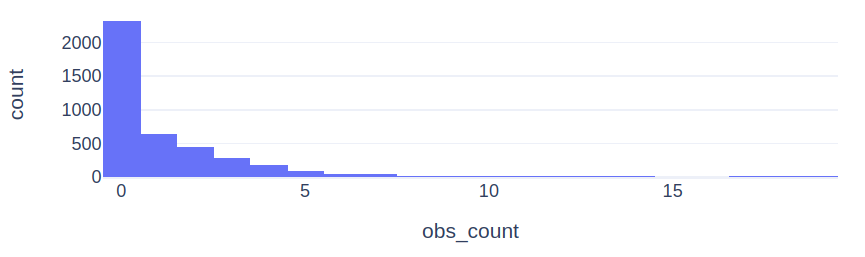

In [9]:
Image("../Resources/img/eda-obs-count.png")

The plot above shows some very high counts on the right hand side (above $count=5$). It will be very challenging to predict these numbers and only a model with a very *high variance* would be able to do that. However, as mentioned in the [Literature Review](./02.LiteratureReview.ipynb#fcst-begin), such a model is not a good choice, as it will often perform poorly on the test-data (due to memorizing the data instead of pattern learning).

**Missing values**

One of the benefits of manually collected dataset is that there is no missing data. However very often when one is given a dataset a decision needs to be made about the treatment of missing data (remove records, try to impute the values or mark as missing).

**Outliers**

Below is the plot of weather related numerical features, where outliers will be visible:

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.7. Feature Histograms</p>

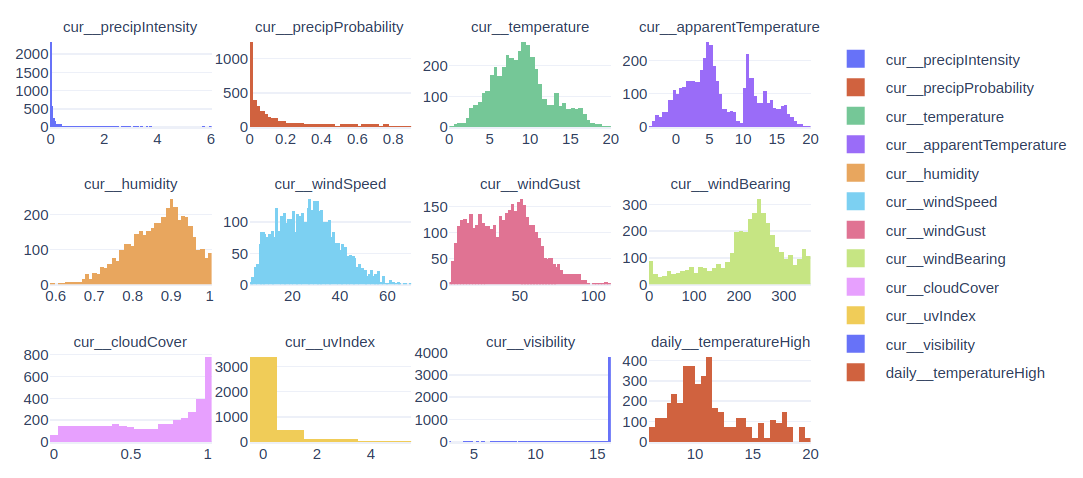

In [10]:
Image("../Resources/img/fcst-outliers.png")

It is clearly visible that *precipitation*, *uvIndex* and *visibility* are heavily skewed and contain serious outliers.

This can often negatively affect the predictive power of the models, especially if they assume that the features are normally distributed or does not contain outliers.

The most popular method for dealing with outliers is to transform the features using one of the following transformations:

- square root - $\sqrt{x}$
- natural logarithm - $\mathcal{log}(x)$
- reciprocal transformation -$1/x$

Sometimes it is also accepted to remove observations with outliers all together, however in case of forecasting it would mean a loss of continuity in the data.

The good part of this exercise is that the Machine Learning algorithms I have tried, have produced the same results with and without these transformations, so I have decided to not transform the features, as if there are not transformed - they are easier to understand and interpret.

**Feature co-linearity**

If independent variables ($x$) are correlated with each other, it can be a problem for the statistical models (like Linear Regression). One way to analyze the effect of features on each other is to plot a correlation matrix:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.8. Feature correlation</p>

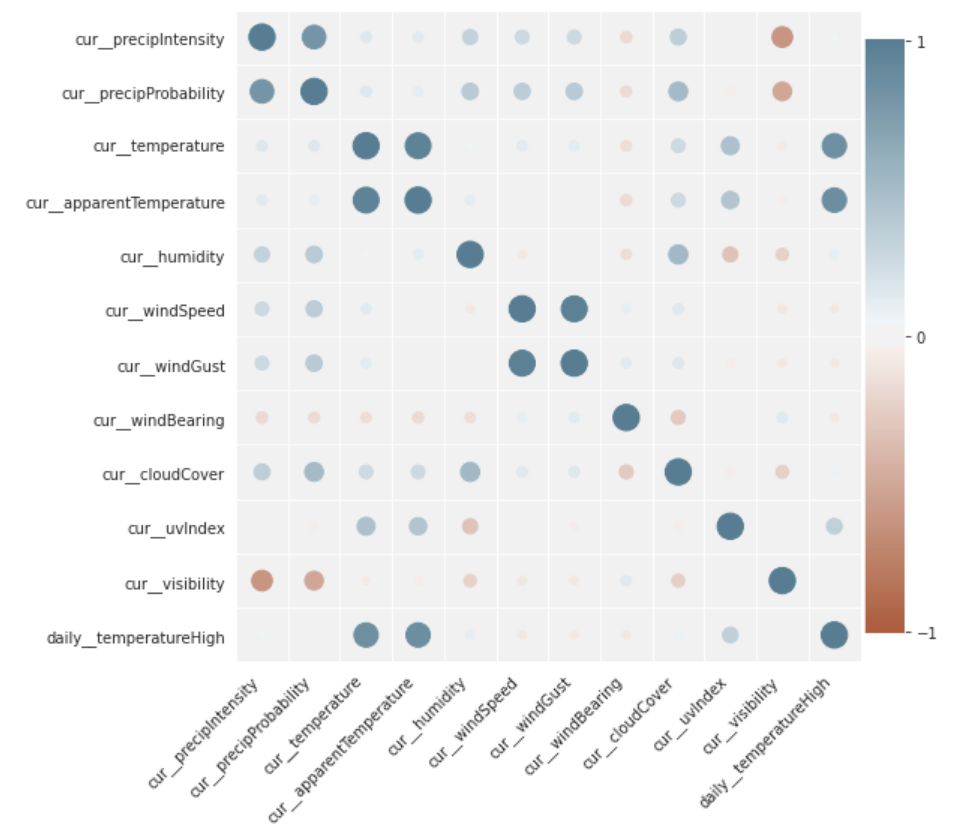

In [11]:
Image("../Resources/img/corr-heatmap.png")

This kind of plot can be really useful as it helps to discard features, which are too correlated with each other, influence the speed of training and (in terms of statistical models) decrease coefficients.

Colors show the direction of correlation (blue is negative and red positive), and the size plus opacity of the circles show the strength of the relationship.

It is clear from the graph (and makes logical sense) that `apparentTemperature` will be highly correlated with `dailyTemperature` and that `humidity` is somewhat correlated with the `cloudCover`.

## 5.6. Predicting counts

This section covers the following activities in order to predict object counts, given the available dataset:

- create a naive model (without Machine Learning) and calculate error rate
- use feature selection techniques to see which features should be included in the ML model
- train several Machine Learning models and calculate error rate
- conclude with a recommendation of the method to use going forward

### 5.6.1. Naive model

*\"All models are wrong, but some are useful\"* (Box 1976).

Starting with a naive method to generate predictions is often a good idea, as the result is a baseline model to beat with more sophisticated methods.

**Idea**:

Grouping the dataset by hour and calculating a mean of object counts forms a very basic forecast method.

$$forecast(X_h)=roundInt(\frac{1}{n}\sum_{i=1}^{n}x_i)$$

, where $X_h$ is the training dataset containing all observations for a given hour $h$, and $n$ is a number of observations in that training set.

**Benefits**:

- it is easy to understand and explain
- it is also fast to compute and requires low resources
- it works for each object class without tweaking features or parameters

**Downsides**:

- it has low accuracy
- it does not take into account other factors (like *weather-type* or *day-of-week*)
- it is skewed by outliers in the target variable
- it does not provide the uncertainty about the results

**Implementation**:

- split dataset into training and test sets 5 times (5-Fold *Cross Validation*) and for each fold:
- calculate mean averages for each hour
- calculate metrics against the test-set:

- Mean Poisson Deviance:

$$MPD=\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}2(y_i log(y/\hat{y}_i) + \hat{y}_i - y_i)$$

, where $\hat{y}_i$ is the i-th predicted value, and $y_{i}$ is the i-th true value [(source)](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-tweedie-deviance)
        
- Mean Absolute Error:

$$MAE=\frac{1}{n}\sum_{i=1}^{n}|y_{i}-\hat{y}_i|$$

- Mean Squared Error:

$$MSE=\frac{1}{n}\sum_{i=1}^{n}(y_{i}-\hat{y}_i)^2$$

- R2 Squared:

$$r2=1-\frac{SS_{res}}{SS_{tot}}$$

, where $SS_{res}$ is the sum of squares of residuals and $SS_{tot}$ is the total sum of squares [(source)](https://en.wikipedia.org/wiki/Coefficient_of_determination)

- Accuracy:

$$
acc=\begin{cases}
    1, & \text{if $predicted = true$}\\
    0, & \text{otherwise}
\end{cases}
$$

Below are the values calculated for the Naive model:

<p style="text-align: center; margin-bottom: 0;">Tbl. 5.1. Error metrics - Naive model</p>

| Metric | Score |
| -------| ------|
| MPD    | 1.42  |
| MSE    | 2.81  |
| MAE    | 0.94  |
| R2     | 0.27  |
| ACC    | 0.49  |

Looking at the metrics above, the errors are quite high considering that the count values are low. The R2 Score of $0.27$ is considered a relatively poor indicator of the predictive power, but at the same time it is not Zero (which would mean that model is not able to predict any variability in the response).

Distribution of errors made by this model:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.9. Error distribution - Naive model</p>

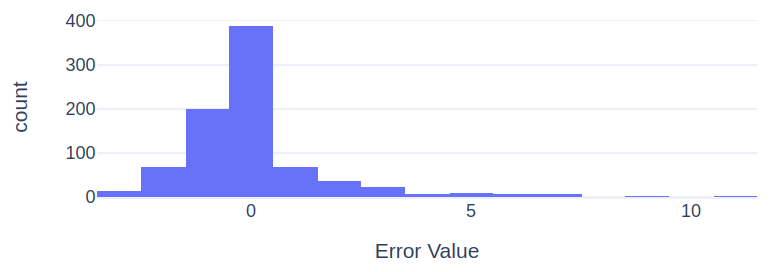

In [12]:
Image("../Resources/img/fcst-error-naive.png")

As expected, the high counts on the right hand side is where the model made bigger errors.

It has also overestimated a lot of values. This means that the model is biased, and in general, bias in Machine Learning is not a good symptom. For this model there is no greater penalty for over or under-estimating values, so the goal should be as little skew as possible in the distribution of errors (close to *Normal*).

This is not always the case. For example in *Business Analytics* forecasting, it might be better to overestimate the demand and build extra stock, than not being able to sell products to the customers due to over-constrained supply.

Even though there are clear indicators of problems in this model, it is still very useful.

It can now be queried for an expected count at a given hour:

- 4AM - $0$
- 6AM - $0.61$, which can be rounded up to $1$ (or Poisson probability density can be used to estimate probabilities for each count, this will be explored later)
- 4PM - $2.99$, which can be rounded up to $3$

These predictions are actually not very wrong, and they are quite inline with the general expectations, given the three scenarios above.

### 5.6.2. Machine Learning

Predicting object counts can be framed as a Supervised, Machine Learning problem. The historical counts are the target values ($y$), and  other factors, like `hour`, `day-of-week`, `temperature`, `precipitation` are the input features ($X$).

The tricky nature of the target values is that even though they are numeric, they are not continuous, but rather a special case of a Binomial Distribution, where the number of trials goes to infinity.

The counts are non-negative integers $\{0,1,2,3,4...\}$and can be modeled using *Poisson Process*, where one would estimate rate ($\lambda$) of observations in a given time interval, and use a simple set of equations to answer questions like:

- Given $\lambda$ and a time interval, what is the probability of seeing next observation in the next $15$ minutes?
- Given $\lambda$, what is the probability of seeing $6$ (or any number) observations in a time interval?

This chapter includes results for the following Machine Learning models:

- Decision tree regressor (and Vanilla Decision Tree as warm up to a more complex model)
- Gradient boosted decision tree regressor
- Gaussian Process

I have also tested many other models:

- Linear Regression
- Support Vector Machines
- Feed Forward Neural Networks
- Long-Short Term Memory Recurrent Neural Networks

However, apart from a good experience in training a broad number of Machine Learning models, I have not found them to be beneficial to this research:

- some were too simple to capture complex, non-linear relationships (Linear Regression)
- some were too complex or unstable for the data volumes and much slower to train and iterate on (LSTM Neural Networks)

### 5.6.3. Feature Selection for Machine Learning

Before applying Machine Learning to the problem, the correct features to use should be identified. Below are the 3 methods, which I have applied in this research:

- select K-Best using statistical test
- feature importances
- correlation matrix

**K-Best features**

The aim of this technique is to test using statistical methods the linear relationships between features and a target variable. For regression problem it uses Pearson correlation:

$$
corr=((x - \mu_x) \cdot (y - \mu_y)) / (\sigma_x \cdot \sigma_y)
$$

Correlation is then transformed to an F Score, and then p-value [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html).

Below are some useful statistics for the sample best $8$ features:

<p style="text-align: center; margin-bottom: 3px;">Tbl. 5.2. KBest feature selection</p>

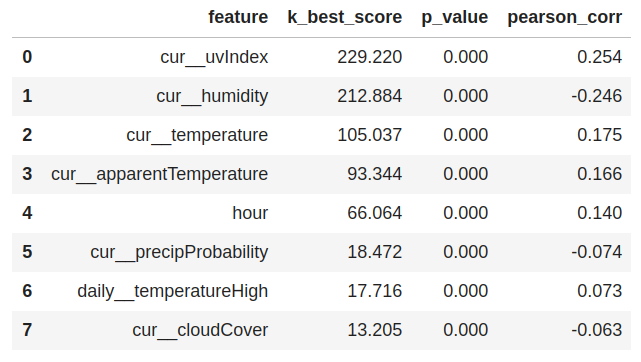

In [13]:
Image("../Resources/img/kbest.png")

The statistical tests often focus on the notion of the *null hypothesis*, which is an assumption that a feature does not have a significant relationship with a target variable.

The *p-value* is a probability used to determine if the null hypothesis can be rejected (meaning there is a correlation):

$$
X=
\begin{cases}
  0, & \text{if}\ a=1 \\
  1, & \text{otherwise}
\end{cases}
$$

Looking again at the table Tbl. 5.2., all features have $p<0.05$, so they do influence the count of objects, where the last column (`pearson_corr`) determines the strength and direction of the correlation.

Plot below shows a jointplot between the best feature `cur__uvIndex` and `obs_count` (for $800$ samples, which is $25\%$ of the training dataset):

<p style="text-align: center; margin-bottom: 0;">Fig. 5.10. KBest jointplot</p>
<img src="../Resources/img/btest-jointplot1.png" style="width: 40%;"/>

Since the Pearson correlation between the UV-Index and count of observations is positive ($0.331$), then it means that the count of observations increases linearly when UV-Index increases.

Looking at all the correlations between all features and the target variable shows a following picture:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.11. KBest - correlations with Target Variable</p>

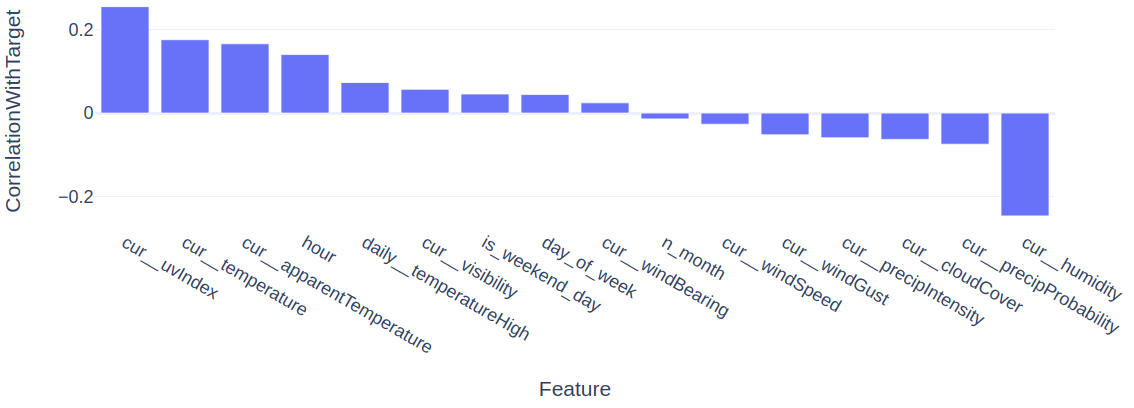

In [15]:
Image("../Resources/img/kbest-corr-all.png")

**Drawbacks**:

While it is always advised to verify the relationships between variables, the approach above assumes that they are linear. In the real-life however, this assumption very often crumbles and there might be a weak dependency between the features as well, which may be difficult to deal with. As a rule of thumb, features should not be discarded too easily.

As usual, detail implementation, more techniques and additional commentary for the plots can be found in the [Extra Notebook 5](../Notebooks/Extra.05.Person-EDA-Forecast.ipynb).

### 5.6.4. Decision Tree

Decision Trees are one of the most basic and easy to interpret ML models. They do not require data scaling, and can be used for both: Data Analysis and Machine Learning (classification and regression).

The theoretical aspect of Decision Trees has been covered in the [Literature Review Chapter](../Chapters/02.LiteratureReview.ipynb), but in a nutshell model searches for the best features and values to split the dataset, so the nodes in the tree fall into two groups separating the Target Variable values.

When trained on the Person object counts dataset, as expected, the algorithm chose to split the dataset by *UV-Index* in the root node, and then by *hour* and *temperature*. This can be observed in the visualization below:

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.12. Decision tree - nodes</p>
<img src="../Resources/img/tree.png" style="width: 55%;"/>

Below are the results achieved from running a 5-fold Cross Validation on this model:

<p style="text-align: center; margin-bottom: 0;">Tbl. 5.3. Error metrics - Decision Tree</p>

| Metric      | Person-Score |
| ----------- | ------------ |
| MPD         | 1.39         |
| MSE         | 2.73         |
| MAE         | 0.92         |
| R2          | 0.29         |
| ACC         | 0.53         |

This is already a an improvement over the naive model, which had the $R2\ Score=2.24$.

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.13. Decision tree - error distribution</p>
<img src="../Resources/img/fsct-errors-dt.png" style="width: 60%;"/>

The error distribution looks more evenly spread, which means that the model is less biased than the Naive model.

### 5.6.5. Gradient Boosting Regressor Tree

There are many extensions of a Decision Tree model to make it more generalizable to unseen data.

Gradient Boosting Trees use a more advanced mathematically technique to calculate the gradient of a loss function (like mean squared error) to find optimal parameters to reduce the errors.

The implementation in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) is designed to work well with larger datasets and generalizes better, as it does not have to search across all feature values to find the best split value, but creates $N-bins$ instead.

This model, cross validated across $5$ folds with hyper-parameters estimated using a GridSearch across $10K$ models is capable of achieving the following results:

<p style="text-align: center; margin-bottom: 0;">Tbl. 5.4. Error metrics - Gradient Boosted DT</p>

| Metric | Score  |
| ------ | ------ |
| MPD    | 1.25   |
| MSE    | 2.47   |
| MAE    | 0.87   |
| R2     | 0.36   |
| ACC    | 0.54   |

Looking at the R2 Score, this model achieves a significantly higher goodness of fit $R2\ Score=0.36$.

**Benefits**:

- due to the usage of gradients and multiple training passes, there is an opportunity to see how the error decreases over time on the training and testing sets. This is a common strategy in Neural Networks, but not so often in the Sci-kit Learn framework models
- the model runs very fast, considering how much computation is happening behind the scenes
- this regressor also allows to use a Poisson loss function, which is the most suitable loss for the count datasets (please refer to the [Literature Review Chapter](../Chapters/02.LiteratureReview.ipynb) for the theory and application of the Poisson distribution
- the plot below shows a good convergence after $400$ iterations (validation curve is flattening) and there are no signs of overfitting (validation curve is not increasing):

<p style="text-align: center; margin-bottom: 10px;">Fig. 5.14. Loss curve - Gradient Based Decision Tree</p>
<img src="../Resources/img/loss-curve-gbdt.png" style="width: 70%;"/>

**Drawbacks**:

- the drawback to this model is that it is not easy to interpret the multiple trees generated inside the algorithm and that it is much more complex than the simple Decision Tree model. Obviously this also a benefit, as it is also much more capable
- the predictions from the model are point estimate, which means that this model does not return the uncertainty about the results, so it is difficult to reason about where model was and was not confident about the generated outputs

**Error Distribution**:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.15. Error distribution - Gradient Based Decision Tree</p>

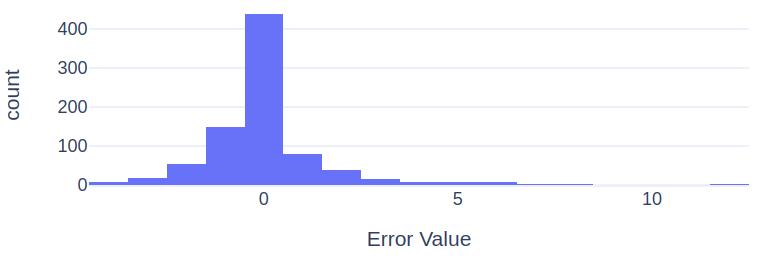

In [16]:
Image("../Resources/img/fcst-errors-gbdt.png")

Similar to vanilla Decision Tree model, the errors are distributed quite evenly, which is a good sign of a weakly-biased model.

### 5.6.6. Gaussian Process

The last model tested in this chapter is the Probabilistic Model using Bayesian inference method to update beliefs after observing the data.

Model uses an *RBF kernel* as a covariance function with $1.0$ for `variance` and `lengthscale` and a Poisson family function is used as a likelihood.

Training and optimizing parameters converges after $18$ iterations, in under $4$ minutes.

The default optimizer in the *GPy* Python Gaussian Process framework utilized is gradient based (using *L-BFGS-B* optimization algorithm by default). This can be displayed by using a verbose output in the model's `optimize` step.

The count of optimized parameters is $N\_Features + 1$, as it is a lengthscale for each feature and one parameter for the variance. All values can be inspected by accessing them as the properties of kernel object (`model.kernel`).

Below are some findings about using Gaussian Process for Machine Learning:

**Drawbacks:**

- choosing a library was a problem. The most popular choice - [pymc3](https://docs.pymc.io/) - consumed over $20GB$ of RAM on a Gaussian Processes with only single feature, and I have switched to another package - [GPy](https://gpy.readthedocs.io/en/deploy/index.html)
- some functions in GPy use deprecated features from other libraries, and warnings need to be explicitly silenced
- speed of training can be a problem as well. In comparison to Gradient Boosting Decision Trees it is very time consuming ($4$ minutes at minimum versus $10$ seconds)
- online documentation is very limited and often outdated
- it is quite common to come across numerical instability issues
- model, which works well for a *Person* class does not work so well for other classes any more, and additional search for good features/parameters is required

**Benefits:**

- the errors produced by this model are the lowest from all the models tested
- there is a clear interpretation of the results in the context of count data
- due to the access to full covariance and mean functions, there is an opportunity to sample from the posterior and treat the standard deviation of sampled functions as a measure of uncertainty, which can be used to improve the credibility of predictions

**Generating Predictions:**

<a id="gp-rates"></a>
The process of generating predictions using GPy is quite interesting:

- First objective (like in most of probabilistic frameworks) is to draw $N$ samples from the Posterior. Usually, a large enough number, like $500$ is sufficient
    - The `predict_noiseless` function gives the mean functions of the Gaussian Process and the full covariance matrix
    - These two objects are then used to sample from a multivariate normal distribution (this can be actually called sampling from the Posterior in Bayesian terminology), which generates the data of shape ($N\_predictions$ $x$ $N\_samples$), for example if there are $800$ predictions and the chosen sample size is $500$, then the shape of the sampled data is $800\times500$
- The sampled functions need to be transformed through $exp(x)$, which also ensures no negative intensities (there can not be a negative count)
- The mean rates ($\lambda$) can be estimated by averaging the exponentiated sampled functions
- Calculating standard deviation ($\sigma$) from exponentiated sampled functions can be interpreted as a measure of uncertainty around predictions

With values for $\lambda$, it is now possible to obtain counts for the predictions (or even more granular - a probability for each count, like $\{0,1,2...20\}$).

It is also possible to answer questions like: how many objects to expect in the first $12$ minutes of the current hour?

With values for $\sigma$, uncertainty can be exploited to influence predictions, for example if uncertainty is low it could be sufficient to show a single number, but if the uncertainty is high, perhaps a better idea would be to show a range of most probable answers.

Below is an example for how a count of events be obtained from a mean rate:

- choose a random predicted rate $\lambda$
- then Poisson probability mass function (*pmf*) can be used to generate probabilities for each number of events. This is calculated using the following equation:

$$
p(X=K) = \frac{\lambda^K}{K!}e^{-\lambda}
$$

- then an array index at the highest probability is the the most probable count for a given time interval

Below is a graph, which shows probabilities ($y$ axis) for each count of events (axis $x$), and marks the true observation as a red dot. The predicted $\lambda$ is $0.365$.

<p style="text-align: center; margin-bottom: 0;">Fig. 5.16. Poisson PMF</p>

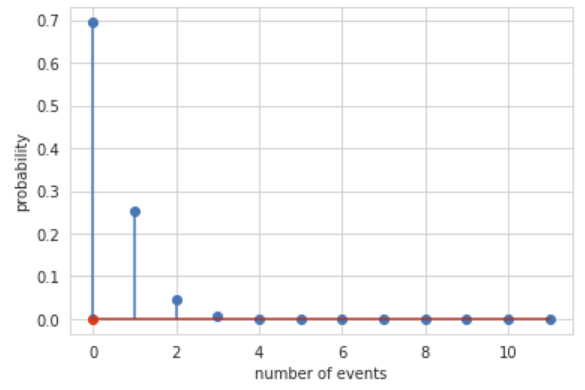

In [18]:
Image("../Resources/img/poisson-proba.png")

In the above plot, the highest probability is at the $0$ number of events, and the true value is also $0$. The probability for obtaining $0$ is estimated at $0.694$.

Next, to explain this prediction, it is possible to find a corresponding observation in the test data:

<p style="text-align: center; margin-bottom: 5px;">Fig. 5.17. Poisson PMF - Test observation</p>

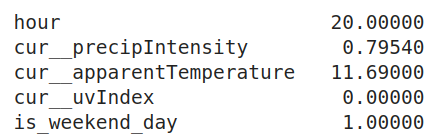

In [19]:
Image("../Resources/img/poisson_proba_test.png")

**Interpretation**:

For 8PM on a weekend, with relatively mild temperature (~$12$ degrees C) and $0.8$ inches of of liquid water per hour ([DarkSky](https://darksky.net/dev/docs)), there is a $70\%$ of probability that there will be no objects within an hour, with $25\%$ chance that there will be a single object.

Based on the information gathered so far, error metrics can be already calculated for the estimated mean rates:

<p style="text-align: center; margin-bottom: 0;">Tbl. 5.5. Error metrics - Gaussian Process</p>

| Metric      | Person-Score |
| ----------- | ------------ |
| MPD         | 1.21         |
| MSE         | 2.35         |
| MAE         | 0.87         |
| R2          | 0.33         |
| ACC         | 0.50         |

This is interesting as the mean Poisson deviance and mean squared error were further reduced, but the rest of metrics did not benefit from this approach.

The error distribution is actually very similar to the Gradient Boosted Decision Tree model.

**Uncertainty analysis**

By calculating Standard Deviation $\sigma$ across the sampled exponentiated functions, it can be used to measure uncertainty.

The plot below shows the distribution of $\sigma$ across all predictions:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.18. Uncertainty Histogram</p>

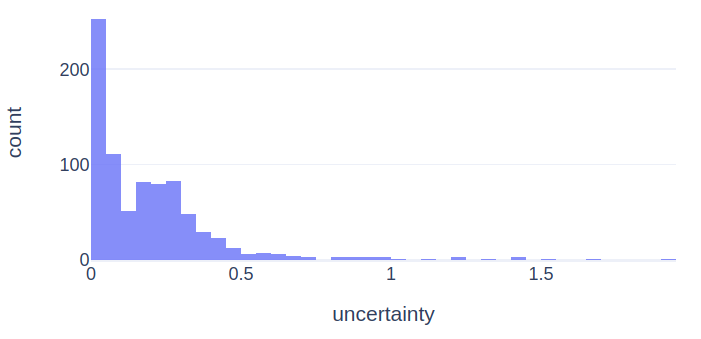

In [20]:
Image("../Resources/img/uncertainty-distribution.png")

It is clearly visible that there is almost zero uncertainty around some predictions and a little more in others. Overall the average of uncertainty is $0.20$.

Plots below show counts and hours in low and high uncertainty scenarios:

<p style="text-align: center; margin-bottom: 0;">Fig. 5.19. Low Uncertainty predictions</p>

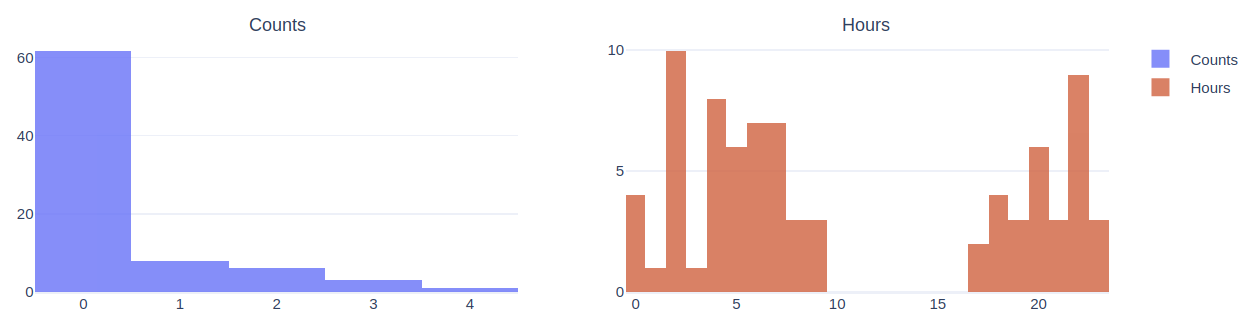

In [21]:
Image("../Resources/img/low-uncertainty.png")

<p style="text-align: center; margin-bottom: 0;">Fig. 5.20. High Uncertainty predictions</p>

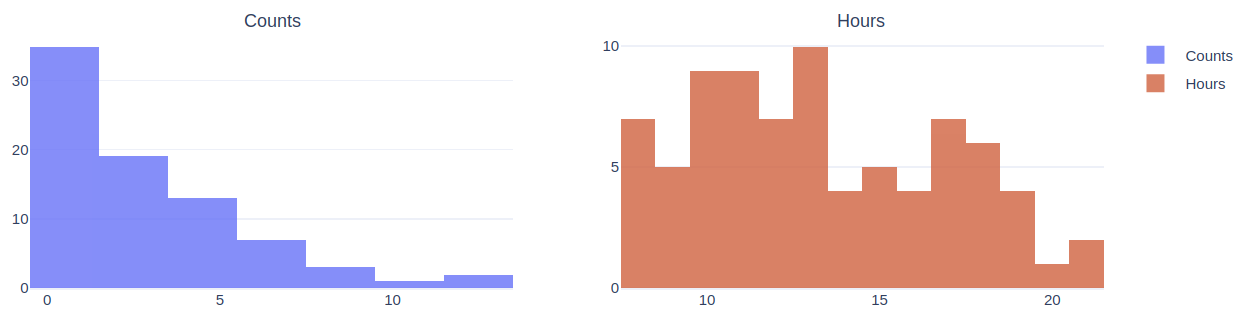

In [22]:
Image("../Resources/img/high-uncertainty.png")

Both groups above are using the same number of samples ($80$) for a meaningful and fair comparison.

It is easy to notice that the predictions during the nightly hours have higher confidence and during the day it is more difficult for the model to be confident.

This is a big advantage of using probabilistic models versus the point estimates generated with sklearn. This idea is explored more below, where uncertainty is embedded in the predictions.

Let the goal be to show to the user a distribution of probabilities for each count ($\{0,1,2,...,8\}$) in a form of a bar chart.

This distribution can be generated from all sampled rates ($500$ floating point rates for each record in $X_test$), and it can be interpreted as embedding uncertainty in the probabilities.

The list of steps to generate such probabilities are listed below:

- choose $N-counts$ for all sampled rates in a single prediction set (where $N$ equals the length of sampled means) using a random choice from a Poisson distribution
- count unique values for each count value
- calculate probability for obtaining individual counts

This *sampling* function is fast and generates $828$ predictions in under $0.2$ of a second.

These steps are wrapped in the `gen_fcst_probas` function, which returns:

- the most probable count
- numbers, for which probability was at least $0.05$
- counts for the numbers, for which probability was at least $0.05$
- probabilities > $0.05$

**Note:** Number $0.05$ has been chosen arbitrarily to discard very low predictions.

To make it clear, below is an example of a call and response from this function:

```python
# let sampled_rates be a 500 sampled rates for a single prediction
expected_count, numbers, counts, probas = gen_fcst_probas(sampled_rates)
```

Output:

- expected_count: 2
- numbers: \[0 1 2 3 4 5\]
- counts: \[246 556 649 520 301 150\]
- probas: \[0.0984 0.2224 0.2596 0.208 0.1204 0.06 \]

Then, another function is used to visualize this data to the user. Below are the bar charts for three different magnitudes of uncertainty:

Visualization for low $\sigma$ ($0.005$):
<p style="text-align: center; margin-bottom: 0;">Fig. 5.21. Low uncertainty predictions</p>

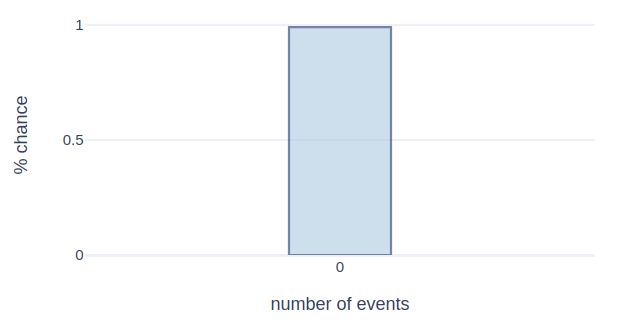

In [23]:
Image("../Resources/img/low-uncertainty-vis.png")

Visualization for medium $\sigma$ ($0.149$):
<p style="text-align: center; margin-bottom: 0;">Fig. 5.22. Medium uncertainty predictions</p>

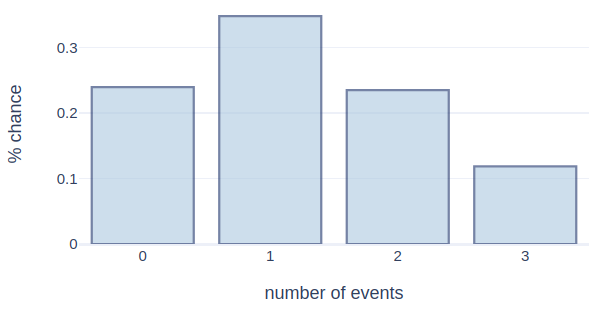

In [24]:
Image("../Resources/img/medium-uncertainty-vis.png")

Visualization for high $\sigma$ ($3.295$):
<p style="text-align: center; margin-bottom: 0;">Fig. 5.23. High uncertainty predictions</p>

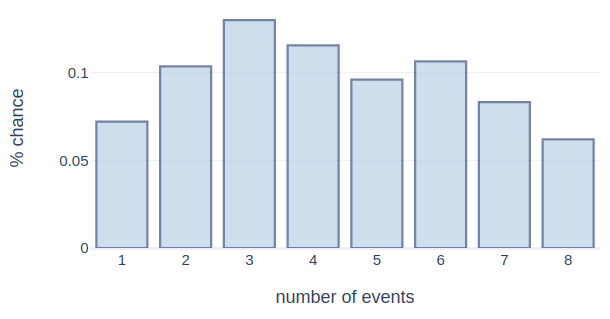

In [25]:
Image("../Resources/img/high-uncertainty-vis.png")

Looking at all the estimations, below is the distribution of number of bars, which would be visible to the users for the predictions:

<p style="text-align: center; margin-bottom: 5px;">Tbl. 5.6. Forecast UI - # of bars for predictions</p>

| Bar count   | # of predictions |
| ----------- | ---------------- |
| 1           | 188              |
| 2           | 141              |
| 3           | 83               |
| 4           | 102              |
| 5           | 140              |
| 6           | 152              |
| 7-9         | 22               |

Please note that all functions, which were required to calculate count ranges, estimate probabilities, and create plots above, are defined in the [Extra Notebook 5](../Notebooks/Extra.05.Person-EDA-Forecast.ipynb#gp-funcs).

**Other opportunities**

Given the mean intensities, it is also possible to answer very useful questions, like:

- What is the probability to see an object at time greater than $t$ given the rate $\lambda$?

$$
p(t)=exp(-\lambda * t)
$$

So if one wants to know probability of a count after $48$ minutes past the hour and $\lambda$ is $1.89$, then the result is $22\%$.

- What is the probability to see an object at time less or equal $t$ given the rate $\lambda$?

$$
p(t)=1 - exp(-\lambda * t)
$$

So if one wants to know probability of a count in less than $12$ minutes and $\lambda$ is $1.89$, then the result is $31\%$.

This could be very useful in a full blown AI speech-enabled system, where users could ask these questions and get instant answers from the AI, however I am leaving this idea for a future exercise.

<a id="conclusion"></a>
## 5.7. Conclusion

Using object detections, Machine Learning can be used to make future predictions. Evidence above shows that even though the models' performance is far from being always correct, it is significantly better than using a naive approach of average counts per hour.

**Model Summary**:

In summary, all models described in this Chapter are very robust, all have their benefits and trade-offs, and all ended up with different error rates. Below is a quick comparison of Pros and Cons for each model inside this chapter:

Naive model:

- $+$ simple to understand
- $+$ very robust
- $+$ fast, little training required
- $-$ highest error rate
- $-$ unable to incorporate additional knowledge
- $-$ can not tell uncertainty for predictions

Decision Tree:

- $+$ very explainable ML model
- $+$ fast to train and use
- $-$ does not generalize well for unseen data
- $-$ can not tell uncertainty for predictions

Gradient Boosted Tree:

- $+$ low error rate
- $+$ can handle large data volumes
- $+$ fast to train
- $+$ ability to visualize training progress and potential overfit
- $-$ difficult to understand decisions made
- $-$ can not tell uncertainty for predictions

Gaussian Process:

- $+$ lowest mean squared error and Poisson deviance out of all models
- $+$ easy to explain for statistical-savvy people
- $+$ can tell uncertainty for predictions
- $-$ slow and challenging to train
- $-$ lack of good, modern libraries and limited documentation
- $-$ does not scale well for larger datasets
- $-$ suffers from poor results on the *Vehicle* object category

**Metrics**:

Below are the error rates for all models in a single table generated for the Person class:

<p style="text-align: center; margin-bottom: 5px;">Tbl. 5.4. Error metrics - All models for Person class</p>

| Metric      | Naive        | Decision Tree | Gradient DT | GP          |
| ----------- | ------------ |---------------|-------------|-------------|
| MPD         | 1.42         | 1.39          | 1.25        | 1.21        |
| MSE         | 2.81         | 2.73          | 2.47        | 2.35        |
| MAE         | 0.94         | 0.92          | 0.87        | 0.86        |
| R2          | 0.27         | 0.29          | 0.36        | 0.33        |
| ACC         | 0.49         | 0.53          | 0.54        | 0.51        |

Looking at the metrics, it seems like starting from the Naive model, the metrics have improved until the Gaussian Process, which improves some and reduces other metrics, however since this is a Poisson process, perhaps Mean Poisson Deviance should be the most reflective of the model's performance.

**Recommendation**:

*Gaussian Process* provided the most useful tools to generate meaningful predictions. It is clear what the model is returning, and the error rate for the *Person* object category is satisfactory.

Being able to embed uncertainty in the predictions gives this model a distinct advantage.

However, at this point - after a limited number of attempts - Gaussian Process achieves quite poor results on the *Vehicle* object category.

This makes the *Gradient Boosting Regressor Tree* a strong competitor, as it is order of magnitude quicker to train, allows to generate learning curves, and it is more robust to object category selection.

[Next Chapter](./06.AnomalyDetection.ipynb) focuses on the Anomaly Detection problem.

[index](../Index.ipynb) | [prev](./04.DataCollection.ipynb) | [next](./06.AnomalyDetection.ipynb)